In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import wkt
from matplotlib import pyplot
import descartes
import seaborn as sns
import datetime as dt
import geoplot as geoplot

In [2]:
#create pandas dataframe of datasets
listings = pd.read_csv('../data/raw/listings.csv')
market_value = pd.read_csv('../data/raw/Market_Value_Analysis__2018_data.csv', index_col = False)
restaurants = pd.read_csv('../data/raw/Culinary_Arts_data.csv', index_col = False)

In [3]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,10291,https://www.airbnb.com/rooms/10291,20200909145511,2020-09-10,Spacious Cottage in Mid-City!,<b>The space</b><br />Spacious house located i...,Navarre is a quiet and quaint neighborhood tha...,https://a0.muscache.com/pictures/99566384/fd1d...,31004,https://www.airbnb.com/users/show/31004,...,10.0,10.0,10.0,"19STR-08424, 19-OSTR-0313",f,1,1,0,0,1.08
1,19091,https://www.airbnb.com/rooms/19091,20200909145511,2020-09-10,Fully Furnished Cozy Apartment,CITY OF NEW ORLEANS STR LICENSE PERMIT NUMBER:...,"NorthWest Carrollton, where this apartment is ...",https://a0.muscache.com/pictures/a5fdfd3b-5d81...,72880,https://www.airbnb.com/users/show/72880,...,10.0,10.0,10.0,"17STR-08877, 20-OSTR-0105",t,1,1,0,0,3.69
2,26834,https://www.airbnb.com/rooms/26834,20200909145511,2020-09-09,Maison Mandeville in the Marigny,<b>The space</b><br />Charming shotgun apartme...,NaN,https://a0.muscache.com/pictures/505025/bee98a...,114452,https://www.airbnb.com/users/show/114452,...,10.0,10.0,10.0,"19STR-10811, 20-OSTR-0389",f,1,1,0,0,2.06
3,71624,https://www.airbnb.com/rooms/71624,20200909145511,2020-09-10,Ravenwood Manor (Historic Bywater),You are in for a very unique stay in a neighbo...,"Ours is a neighborhood made up of artists, mus...",https://a0.muscache.com/pictures/37488608/8cc1...,367223,https://www.airbnb.com/users/show/367223,...,10.0,10.0,10.0,17STR-08285,f,1,1,0,0,1.94
4,74498,https://www.airbnb.com/rooms/74498,20200909145511,2020-09-10,Maison Marais 1: Large Local Living,Maison Marais 1 is a stylish one-bedroom apart...,"This is a vibrant, diverse neighborhood of mos...",https://a0.muscache.com/pictures/73591836/a1f5...,391462,https://www.airbnb.com/users/show/391462,...,10.0,10.0,10.0,"Exempt: This listing is a licensed hotel, mote...",f,2,2,0,0,4.29


In [4]:
print(listings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6408 entries, 0 to 6407
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6408 non-null   int64  
 1   listing_url                                   6408 non-null   object 
 2   scrape_id                                     6408 non-null   int64  
 3   last_scraped                                  6408 non-null   object 
 4   name                                          6408 non-null   object 
 5   description                                   6383 non-null   object 
 6   neighborhood_overview                         4819 non-null   object 
 7   picture_url                                   6408 non-null   object 
 8   host_id                                       6408 non-null   int64  
 9   host_url                                      6408 non-null   o

In [5]:
#dropping columns containing urls because I am not interested in this data right now
url_cols = [col for col in listings.columns if 'url' in col]
listings.drop(columns = url_cols, inplace = True)

In [6]:
str_to_length = ['neighborhood_overview','description','host_about']
str_to_boolean=['instant_bookable','host_is_superhost','host_has_profile_pic','host_identity_verified']
to_int = ['host_response_rate','host_acceptance_rate','bathrooms_text','price']
to_category =['room_type','property_type','host_response_time','neighbourhood_cleansed']
to_date=['first_review','last_review']

In [7]:
#true/false columns were imported as strings 't' or 'f'. This changes them to boolean types
bools={'t':True,'f':False}
for column in listings[str_to_boolean]:
    listings[column] = listings[column].map(bools)

In [8]:
#cleaning up symbols in strings to prepare to convert to floats
listings['host_response_rate']= listings['host_response_rate'].str.replace('%','')
listings['host_acceptance_rate']=listings['host_acceptance_rate'].str.replace('%','')
listings['bathrooms_text']=listings["bathrooms_text"].str.replace(' bath','')
listings['bathrooms_text']=listings['bathrooms_text'].str.replace('s','')
listings['price']=listings['price'].str.replace('$','')

In [9]:
#converts numeric string columns to floats
for col in listings[to_int]:
    listings[col]=pd.to_numeric(listings[col],errors = 'coerce')

In [10]:
#changes date columns to datetime types
for col in listings[to_date]:
    listings[col]=pd.to_datetime(listings[col])

In [11]:
#converts columns to categories 
for column in listings[to_category]:
    listings[column]=listings[column].astype('category')

In [12]:
missing_list = listings.columns[listings.isna().any()].tolist()
print(listings[missing_list].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6408 entries, 0 to 6407
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   description                   6383 non-null   object        
 1   neighborhood_overview         4819 non-null   object        
 2   host_location                 6396 non-null   object        
 3   host_about                    4226 non-null   object        
 4   host_response_time            4801 non-null   category      
 5   host_response_rate            4801 non-null   float64       
 6   host_acceptance_rate          5877 non-null   float64       
 7   host_neighbourhood            5665 non-null   object        
 8   neighbourhood                 4819 non-null   object        
 9   neighbourhood_group_cleansed  0 non-null      float64       
 10  bathrooms                     0 non-null      float64       
 11  bathrooms_text                

In [13]:
all_missing = listings.columns[listings.isna().all()].tolist()
print(all_missing)

['neighbourhood_group_cleansed', 'bathrooms', 'calendar_updated']


In [14]:
listings.drop(columns = all_missing, inplace = True)

In [15]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6408 entries, 0 to 6407
Data columns (total 66 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            6408 non-null   int64         
 1   scrape_id                                     6408 non-null   int64         
 2   last_scraped                                  6408 non-null   object        
 3   name                                          6408 non-null   object        
 4   description                                   6383 non-null   object        
 5   neighborhood_overview                         4819 non-null   object        
 6   host_id                                       6408 non-null   int64         
 7   host_name                                     6408 non-null   object        
 8   host_since                                    6408 non-null   object

In [16]:
#I will drop rows with missing prices since this is the target variable.
listings.dropna(subset = ['price'], inplace = True)
print(listings.shape)

(6350, 66)


In [17]:
#correlation matrix to quickly see if there are any features with missing values that correlate well with features without missing values.

listings.corr().style.background_gradient()


In [18]:
#looks like the complete 'accommodates' feature is strongly correlated with number of rooms, bathrooms and beds.

rooms = ['bathrooms_text','bedrooms','beds']
for column in listings[rooms]:
    print(str(column) +': ' +str(listings['accommodates'].corr(listings[column])))

bathrooms_text: 0.6971949883350812
bedrooms: 0.8629902020445137
beds: 0.8276720250216775


[ 4  3  2  6  7 16 14  5 10  1  8 12 15  9 13 11  0]
AxesSubplot(0.125,0.125;0.775x0.755)


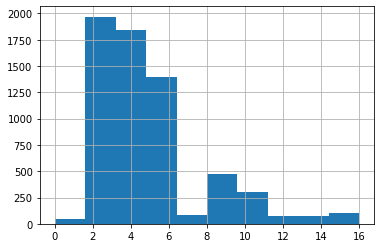

In [19]:
#since there is correation, I'll group by 'accommodates' before filling these features witht the average. This might 
#might give me a more accurate representation 
#First I'll double checking to make sure there aren't any zero values or anything really high 
#in 'accommodates' that looks like a mistake

print(listings['accommodates'].unique())
print(listings['accommodates'].hist())

In [20]:
#looks okay so I'll go ahead and fill in the missing values
for column in listings[rooms]:
    listings[column] = listings[column].fillna(listings.groupby('accommodates')[column].transform('mean'))

In [21]:
#Making column of how many days airbnb has operated as of today's date
print(listings.first_review[:5])
listings["days_active"]=(pd.Timestamp.today() -listings.first_review).dt.days
listings.days_active[:5]

0   2011-03-07
1   2010-04-16
2   2010-07-04
3   2011-02-16
4   2011-03-15
Name: first_review, dtype: datetime64[ns]


0    3585.0
1    3910.0
2    3831.0
3    3604.0
4    3577.0
Name: days_active, dtype: float64

In [22]:
#May want to limit data to airbnbs that have been operating longer because more people might stay in these each month
#but reviews doesn't look to be that correlated with how often they are booked
print(len(listings))
print(len(listings[listings['days_active']>365]))
print(len(listings[listings['days_active']>180]))
print(listings.days_active.corr(listings.reviews_per_month))

6350
4842
5456
0.10780379367285746


In [23]:
listings.drop(columns = ['first_review','last_review'], inplace = True)

In [24]:
#I wasn't able to look at histograms by running them without separating them into integers and floats for some reason
l_ints = []
l_floats = []
for column, dtype in listings.dtypes.iteritems():
    if dtype == 'int64':
        l_ints.append(column)
    if dtype == 'float64':
        l_floats.append(column)

array([[<AxesSubplot:title={'center':'accommodates'}>,
        <AxesSubplot:title={'center':'availability_30'}>,
        <AxesSubplot:title={'center':'availability_365'}>,
        <AxesSubplot:title={'center':'availability_60'}>],
       [<AxesSubplot:title={'center':'availability_90'}>,
        <AxesSubplot:title={'center':'calculated_host_listings_count'}>,
        <AxesSubplot:title={'center':'calculated_host_listings_count_entire_homes'}>,
        <AxesSubplot:title={'center':'calculated_host_listings_count_private_rooms'}>],
       [<AxesSubplot:title={'center':'calculated_host_listings_count_shared_rooms'}>,
        <AxesSubplot:title={'center':'host_id'}>,
        <AxesSubplot:title={'center':'host_listings_count'}>,
        <AxesSubplot:title={'center':'host_total_listings_count'}>],
       [<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'maximum_nights'}>,
        <AxesSubplot:title={'center':'minimum_nights'}>,
        <AxesSubplot:title={'center':'

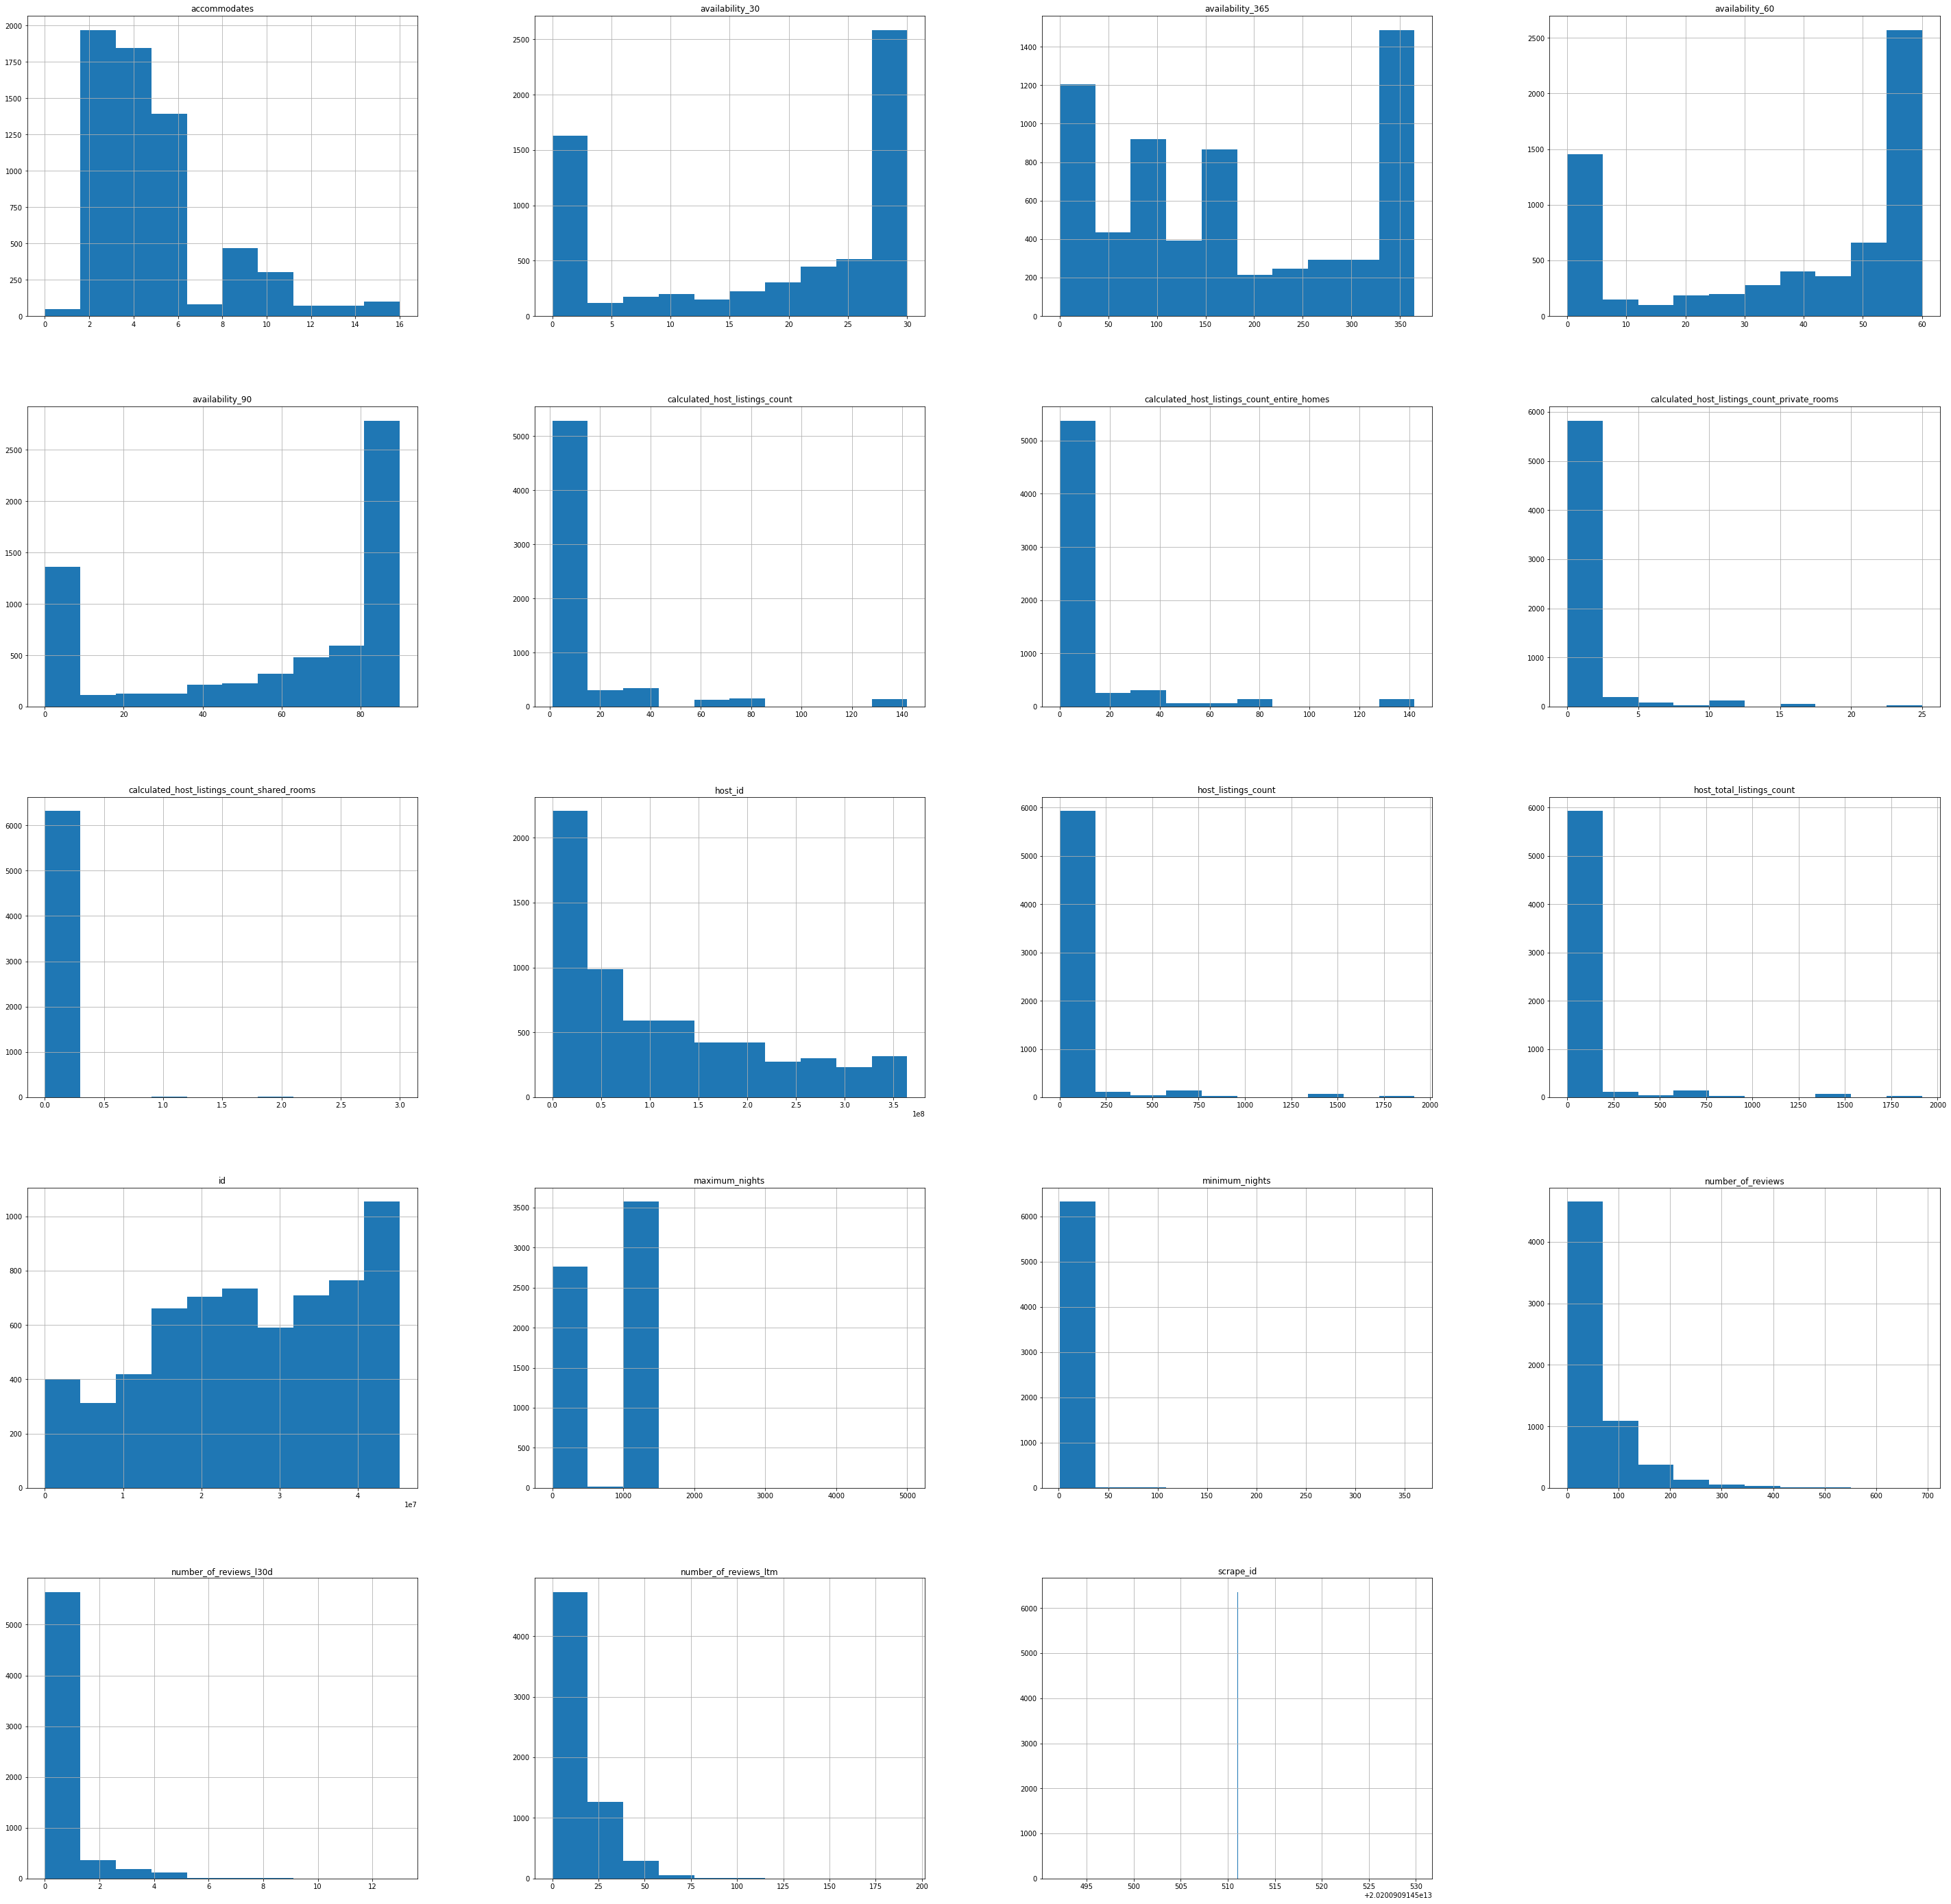

In [25]:
listings[l_ints].hist(bins = 10, figsize=(50,50))

array([[<AxesSubplot:title={'center':'bathrooms_text'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'beds'}>,
        <AxesSubplot:title={'center':'days_active'}>,
        <AxesSubplot:title={'center':'host_acceptance_rate'}>],
       [<AxesSubplot:title={'center':'host_response_rate'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'maximum_maximum_nights'}>,
        <AxesSubplot:title={'center':'maximum_minimum_nights'}>],
       [<AxesSubplot:title={'center':'maximum_nights_avg_ntm'}>,
        <AxesSubplot:title={'center':'minimum_maximum_nights'}>,
        <AxesSubplot:title={'center':'minimum_minimum_nights'}>,
        <AxesSubplot:title={'center':'minimum_nights_avg_ntm'}>,
        <AxesSubplot:title={'center':'price'}>],
       [<AxesSubplot:title={'center':'review_scores_accuracy'}>,
        <AxesSubplot:title={'center':'review_scores_checki

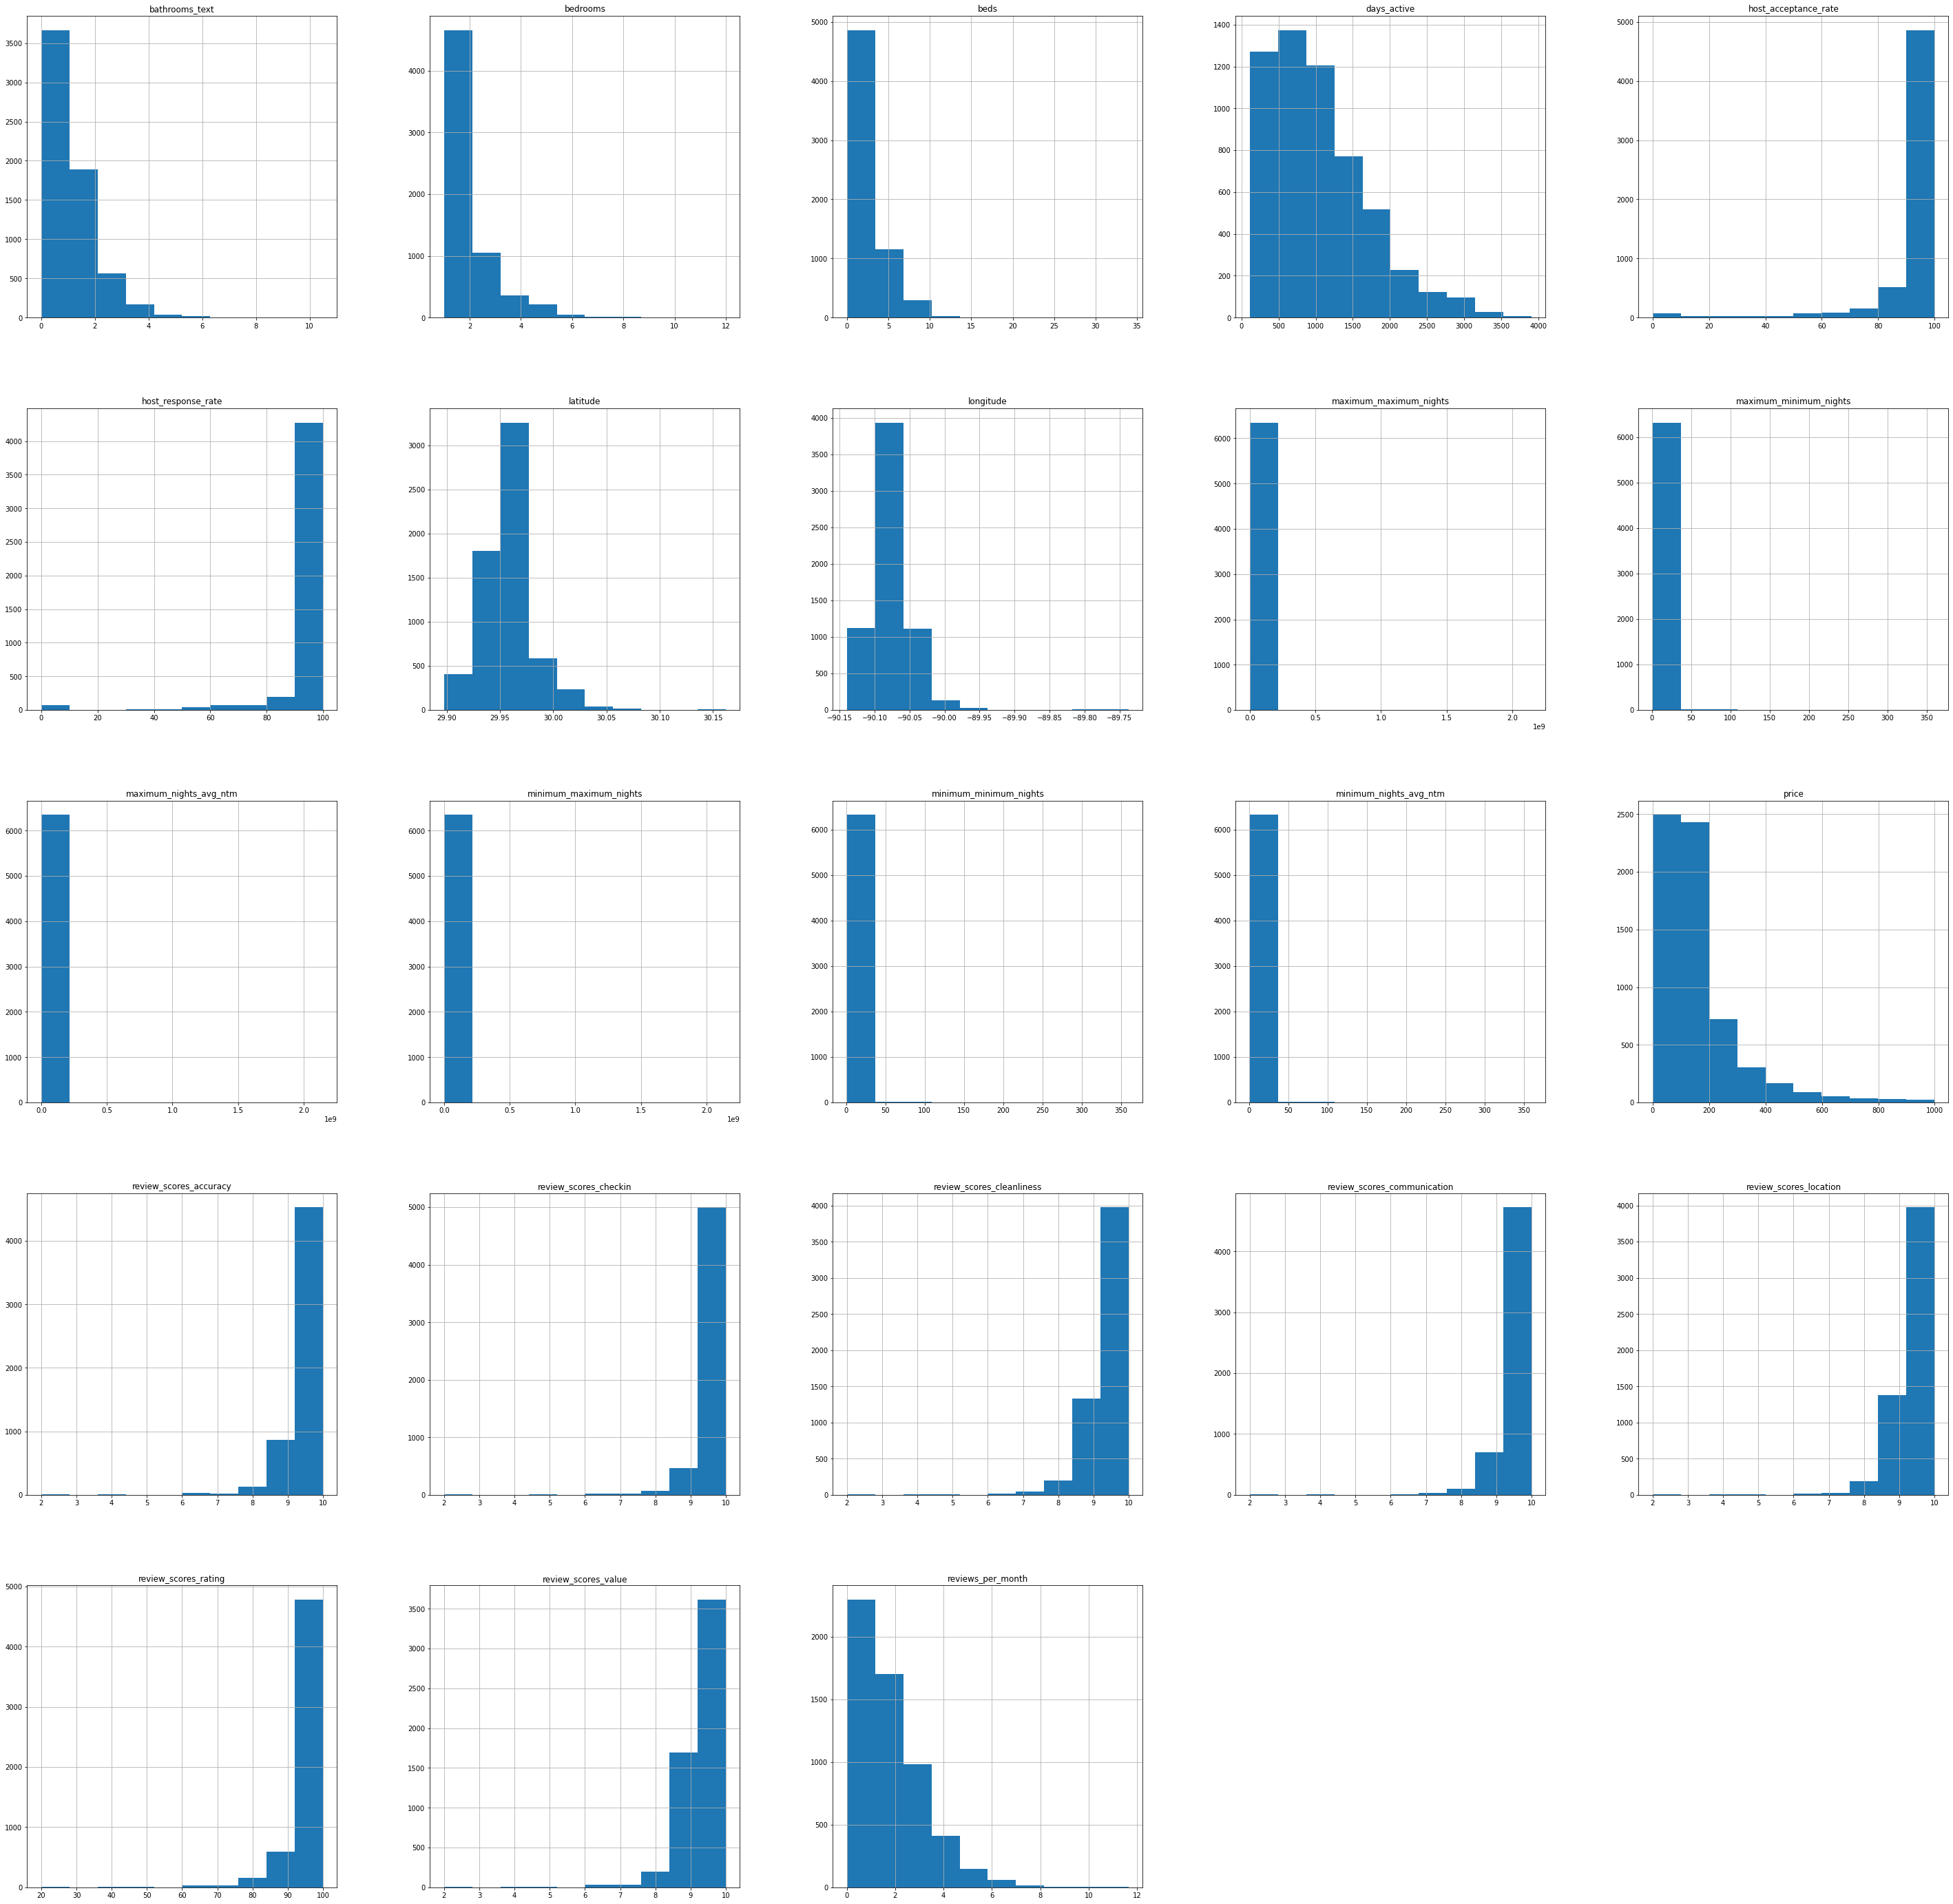

In [26]:
listings[l_floats].hist(bins=10,figsize=(50,50))

In [27]:
#host listings count, looks weird so I'll check it out
print(listings[['name','host_name','host_id','license','host_listings_count']][listings['host_listings_count']>1500])


                                                   name  host_name    host_id  \
4055      Exhilarating Club La Pension, 1 Bedroom Suite  Christian  194953121   
5089      Club La Pension, New Orleans, 1 Bedroom Suite  Christian  194953121   
5145      Club La Pension, New Orleans, 1 Bedroom Suite  Christian  194953121   
5146          Ghouling Club La Pension, 1 Bedroom Suite  Christian  194953121   
5148  The Marquee Resort, New Orleans,1 Bedroom Stan...  Christian  194953121   
5149   The Marquee Resort, 1 Bedroom Deluxe Sleeps Four  Christian  194953121   
5150        The Marquee Resort, Huge 1 Bedroom Standard  Christian  194953121   
5151             The Marquee Resort, 2 Bedroom Standard  Christian  194953121   
5153          The Marquee Resort, Huge 1 Bedroom Deluxe  Christian  194953121   
5154        The Marquee Resort, Huge 1 Bedroom Standard  Christian  194953121   
5155  The Marquee Resort, 1 Bedroom Standard Sleeps Two  Christian  194953121   
5567       The Bayou's Club 

In [28]:
print(listings[listings['host_id']==194953121].shape)
print(listings[listings['host_name']=='Christian'].shape)
print(listings[listings['license']=='Exempt: This listing is a licensed hotel, motel, or bed and breakfast'].shape)
#can't see how this host's host_listings_count can be greater than 28. 1125 at the most, but it showed up filtered by host listing count greater than 1500.

(28, 65)
(35, 65)
(1112, 65)


In [29]:
print(listings[['name','host_name','host_id','license','host_listings_count','calculated_host_listings_count']][listings['calculated_host_listings_count']>100])
print(listings[listings['host_name']=='Hosteeva'].shape)
print(listings[listings['host_id']==24831061].shape)
# calculated host listings count looks to have been determined by host_id and more accurate, so I'll keep it and remove other columns related to number of host listings

                                                 name host_name   host_id  \
1115       Spacious 3BR Condo close to French Quarter  Hosteeva  24831061   
1117         Luxury 4BR Penthouse Near French Quarter  Hosteeva  24831061   
1119                     Luxury 4BR condo in Downtown  Hosteeva  24831061   
1240         Lovely 2BR next to City Park by Hosteeva  Hosteeva  24831061   
1249       Stunning 1BR next to City Park by Hosteeva  Hosteeva  24831061   
...                                               ...       ...       ...   
4938                        Luxury Living in Mid City  Hosteeva  24831061   
5115      Hosteeva | Double on Martin Luther King Jr.  Hosteeva  24831061   
5122  Hosteeva | 2BR Double Steps to St. Charles Ave.  Hosteeva  24831061   
5529                     Lovely 3BR next to City Park  Hosteeva  24831061   
5530                         1812 #3 Luxury 3BR Condo  Hosteeva  24831061   

                         license  host_listings_count  \
1115  20STR-21055,

In [30]:
listings.drop(columns = ['host_listings_count','host_total_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms'],inplace=True)

In [31]:
#columns related to minimum and maximum nights look strange or repetitive in histograms
#New Orleans defines the length of short-term rentals as rentals as less than 30 days
print(listings[listings['minimum_nights']>29].shape)
print(listings[listings['license']=='Long-term host, exempt from registration'].shape)
listings = listings[listings['license']!='Long-term host, exempt from registration']

(1296, 60)
(4, 60)


In [32]:
#there are enough listings with a high minimum nights value to try to figure out a good replacement value rather 
#than deleting them
min_nights = list(listings['minimum_nights'][listings['minimum_nights']>29])
min_nights.sort(reverse = True)
print(min_nights)

[360, 360, 180, 180, 180, 120, 100, 90, 90, 90, 90, 90, 90, 90, 90, 89, 60, 60, 60, 60, 60, 60, 60, 60, 45, 32, 32, 32, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 

In [33]:
#most listings above 29 minimumn nights are 30 nights. They could be listed this way to circumvent some of NOLA's short term rental laws so 
#I'll keep anything 30 nights or fewer.
listings=listings[listings['minimum_nights']<31]

In [34]:
listings.drop(columns = ['minimum_minimum_nights','maximum_minimum_nights','minimum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm'],inplace = True)

In [35]:
#creates a column of estimated earnings per month assuming the guests only stayed the minimum nights
listings['lowest_estimate/month']=listings['price']*listings['reviews_per_month']*listings['minimum_nights']
print(listings["lowest_estimate/month"].head())
print(listings['lowest_estimate/month'].mean())
print(listings['lowest_estimate/month'].max())

0     324.00
1     221.40
2     550.02
3     756.60
4    1184.04
Name: lowest_estimate/month, dtype: float64
1178.4588610382598
49276.50000000001


In [36]:
conditions = [(listings['minimum_nights']>5),(listings['minimum_nights']<=5)]
values = [(listings['lowest_estimate/month']),(listings['price']*listings['reviews_per_month']*5)]
listings['middle_estimate/month']=np.select(conditions, values)
print(listings['middle_estimate/month'].head())
print(listings['middle_estimate/month'].mean())
print(listings['middle_estimate/month'].max())

0     810.0
1    1107.0
2     916.7
3    1261.0
4    1973.4
Name: middle_estimate/month, dtype: float64
1817.8910539428734
49276.50000000001


In [37]:
#these seem really high
#I need to check to see if there are rows where number of reviews per month multplied by minimum_nights
#outnumber the number of days in a month 
#I'm going to remove these rows
print(listings[['minimum_nights','reviews_per_month']][(listings['minimum_nights']*listings['reviews_per_month'])>30])
listings = listings[(listings['minimum_nights']*listings['reviews_per_month'])<30]
print(listings['middle_estimate/month'].mean())
print(listings['middle_estimate/month'].max())
print(listings['lowest_estimate/month'].mean())
print(listings['lowest_estimate/month'].max())

      minimum_nights  reviews_per_month
12                30               1.29
34                30               1.61
36                30               1.21
40                30               1.67
46                30               2.32
...              ...                ...
4884              30               2.47
4910              30               1.42
4914              30               1.85
5008              30               1.64
5980              30               2.12

[400 rows x 2 columns]
1390.6043111003485
18873.0
701.003571483921
18873.0


In [38]:
#host acceptance rate showed some zero values in histogram
print(len(listings[listings['host_acceptance_rate']==0]))

#I'll go ahead and delete these since there are so few
listings = listings[listings['host_acceptance_rate']>0]

40


In [39]:
#deleting listings that have no reviews. I want the model to work on airbnbs that have been 'tested'
print(len(listings[listings['number_of_reviews']==0]))
listings = listings[listings['number_of_reviews'] > 0]

0


In [40]:
print(listings.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4776 entries, 0 to 6382
Data columns (total 56 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              4776 non-null   int64   
 1   scrape_id                       4776 non-null   int64   
 2   last_scraped                    4776 non-null   object  
 3   name                            4776 non-null   object  
 4   description                     4772 non-null   object  
 5   neighborhood_overview           3748 non-null   object  
 6   host_id                         4776 non-null   int64   
 7   host_name                       4776 non-null   object  
 8   host_since                      4776 non-null   object  
 9   host_location                   4767 non-null   object  
 10  host_about                      3297 non-null   object  
 11  host_response_time              3926 non-null   category
 12  host_response_rate  

In [41]:
listings.drop (columns =['neighbourhood','last_scraped','host_neighbourhood','host_id','host_since','has_availability','calendar_last_scraped','number_of_reviews_ltm','license','host_verifications'],inplace=True)

In [42]:
#I could probably fill in some more of the missing values, but I'm happy with this amount of data for now. 
print(listings.shape)

listings = listings.dropna()
print(listings.shape)


(4776, 46)
(2241, 46)


In [43]:
print(listings.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2241 entries, 0 to 6372
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              2241 non-null   int64   
 1   scrape_id                       2241 non-null   int64   
 2   name                            2241 non-null   object  
 3   description                     2241 non-null   object  
 4   neighborhood_overview           2241 non-null   object  
 5   host_name                       2241 non-null   object  
 6   host_location                   2241 non-null   object  
 7   host_about                      2241 non-null   object  
 8   host_response_time              2241 non-null   category
 9   host_response_rate              2241 non-null   float64 
 10  host_acceptance_rate            2241 non-null   float64 
 11  host_is_superhost               2241 non-null   bool    
 12  host_has_profile_pic

In [44]:
print(market_value.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   the_geom                                 496 non-null    object 
 1   OBJECTID                                 496 non-null    int64  
 2   geoid                                    496 non-null    int64  
 3   Median Sales Price                       496 non-null    float64
 4   Coefficient for Variance of Sales Price  496 non-null    float64
 5   Cluster                                  496 non-null    object 
 6   PercentVacantLandSales                   496 non-null    float64
 7   PercentSubsidizedRental                  496 non-null    float64
 8   PercentInspectionViolations              496 non-null    float64
 9   PercentResidentialAddressesVacant        496 non-null    float64
 10  PercentVacantLots                        496 non-n

In [45]:
#I'll only use columns I want for summary statistics and geospatial data.
market_value = market_value[['the_geom','OBJECTID','geoid', 'Median Sales Price','PercentShortTermRentals']]

array([[<AxesSubplot:title={'center':'Median Sales Price'}>,
        <AxesSubplot:title={'center':'OBJECTID'}>],
       [<AxesSubplot:title={'center':'PercentShortTermRentals'}>,
        <AxesSubplot:title={'center':'geoid'}>]], dtype=object)

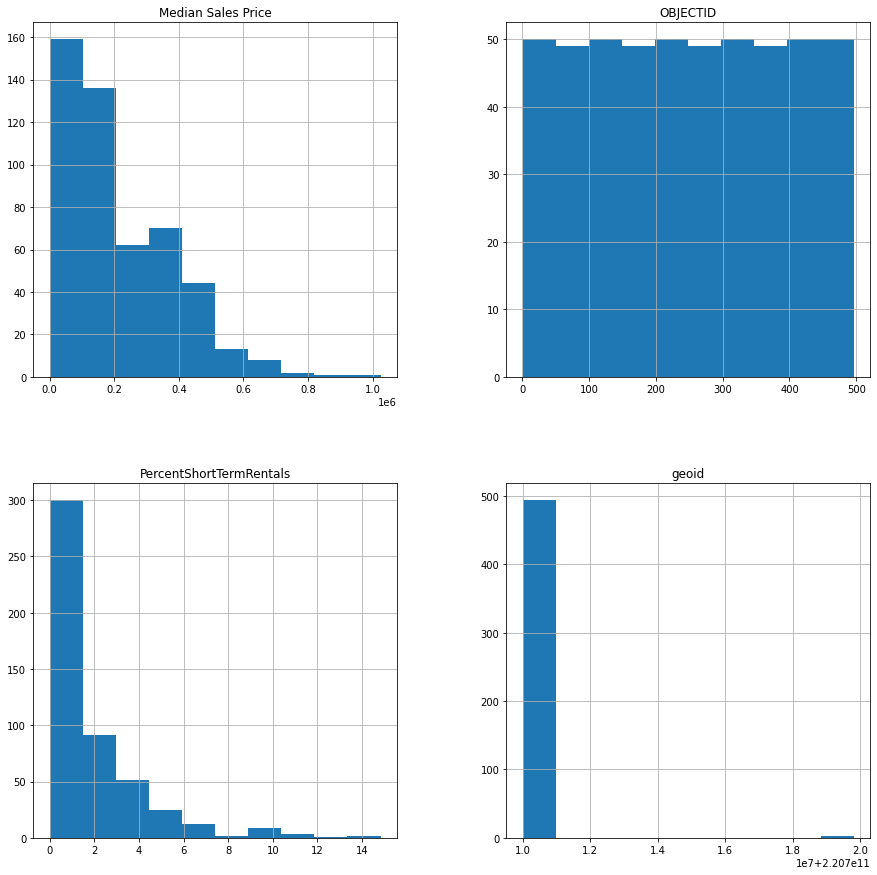

In [46]:
market_value.hist(bins=10, figsize=(15,15))

In [47]:
#converting listings to geodataframe in order to merge with market value data via gps coordinates
gdf_listings = gpd.GeoDataFrame(listings,   geometry=gpd.points_from_xy(listings.longitude, listings.latitude))

In [48]:
#changing the_geom column of market_value to correct type for geodataframe geometry column
market_value['geometry'] = market_value['the_geom'].apply(wkt.loads)

In [49]:
#converting market_value to geodataframe 
m_value_gpd = gpd.GeoDataFrame(market_value, geometry = market_value['geometry'])

In [50]:
#joining based on gps coordinates
sjoined_listings = gpd.sjoin(m_value_gpd, gdf_listings, op= 'contains' )

In [51]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   the_geom  867 non-null    object
 1   OBJECTID  883 non-null    int64 
 2   Name      883 non-null    object
 3   Segment   883 non-null    object
 4   Type      883 non-null    object
 5   Address   878 non-null    object
dtypes: int64(1), object(5)
memory usage: 41.5+ KB


In [52]:
print(restaurants[restaurants['Address'].duplicated()].shape)
print(restaurants[restaurants['Address']=='3901 BANKS  ST'])

#there are some addresses listing multiple restaurants because of a business having retail and dining licenses
#some addresses contain names of previous restaurants and current restaurants
#some addresses are large enough to hold several retaurants
#without spending a lot of time researching this, I think its safe to remove duplicate addresses.  Even it is a food
#court or something, it will be counted as one restaurant. 
restaurants.drop_duplicates(subset = ['Address'], inplace = True)

(48, 6)
                                     the_geom  OBJECTID  \
687  POINT (-90.100966696726 29.970772242784)        37   
742  POINT (-90.100966696726 29.970772242784)       450   

                      Name        Segment           Type         Address  
687  MONA'S PITA BREAD INC  Culinary Arts  Food Products  3901 BANKS  ST  
742            MONA'S CAFE  Culinary Arts     Restaurant  3901 BANKS  ST  


In [53]:
#dropped ojectid from restaurants before merging since it is a duplicate column name
restaurants.drop(columns = 'OBJECTID', inplace = True)
restaurants.dropna(inplace = True)
restaurants['the_geom']=restaurants['the_geom'].apply(wkt.loads)
restaurants_gpd = gpd.GeoDataFrame(restaurants, geometry = 'the_geom')

In [54]:
#joined restaurants to neighborhoods grouped by the number of restaurants in the neighborhood

restaurants_neighborhoods=gpd.sjoin(m_value_gpd, restaurants_gpd, op='contains')

#create dataframe of restaurants counts grouped by 'geoid' which is the district they're in
restaurants_neighborhoods = restaurants_neighborhoods.groupby('geoid').Name.agg('count').reset_index()

In [55]:

#rename

restaurants_neighborhoods.rename(columns = {'Name':'Restaurant_Count'}, inplace = True)


In [56]:
#this is a left join on geoid so that restaurants info will show number of restaurants per district
sjoined_listings = pd.merge(sjoined_listings,restaurants_neighborhoods,how = 'left', left_on = 'geoid', right_on = 'geoid')

In [57]:
sjoined_listings.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2241 entries, 0 to 2240
Data columns (total 54 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   the_geom                        2241 non-null   object  
 1   OBJECTID                        2241 non-null   int64   
 2   geoid                           2241 non-null   int64   
 3   Median Sales Price              2241 non-null   float64 
 4   PercentShortTermRentals         2241 non-null   float64 
 5   geometry                        2241 non-null   geometry
 6   index_right                     2241 non-null   int64   
 7   id                              2241 non-null   int64   
 8   scrape_id                       2241 non-null   int64   
 9   name                            2241 non-null   object  
 10  description                     2241 non-null   object  
 11  neighborhood_overview           2241 non-null   object  
 12  host_name   

In [58]:
#this shows that there are multiple geoids in each neighborhood
print(len(sjoined_listings.neighbourhood_cleansed.unique()))

print(len(sjoined_listings.geoid.unique()))


61
324


In [59]:
#this shows that there are geoids in neighborhoods with no restaurants.
neighborhoods = sjoined_listings.groupby(['neighbourhood_cleansed','geoid']).Restaurant_Count.agg('max')

In [60]:
#this left joins neighborhoods to main dataframe so that each entry
#has a column that shows how many restaurants are in its neighborhood
neighborhoods = neighborhoods.reset_index()
neighborhoods = neighborhoods.groupby('neighbourhood_cleansed').Restaurant_Count.agg('sum')
neighborhoods = neighborhoods.to_frame().reset_index()
neighborhoods.rename(columns = {'Restaurant_Count':'neighborhood_restaurants'},inplace=True)
geolistings = pd.merge(sjoined_listings,neighborhoods,how = 'left', left_on = 'neighbourhood_cleansed', right_on = 'neighbourhood_cleansed')


In [61]:
#this is just some code to show me which neighborhoods the data shows no restaurants for
#These neighborhoods are industrial, highly suburban or very impovershed so it looks reasonable to me
geolistings.update(geolistings[['Restaurant_Count','neighborhood_restaurants']].fillna(0))
print(geolistings.shape)
print(len(geolistings[geolistings['neighborhood_restaurants']>0]))
group = geolistings[['neighbourhood_cleansed','neighborhood_restaurants']].groupby('neighbourhood_cleansed').neighborhood_restaurants.agg('max')
group = group.reset_index()

print(group.info())
print(group[group['neighborhood_restaurants'].isna()])
print(group[group['neighborhood_restaurants']==0])

(2241, 55)
2189
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   neighbourhood_cleansed    71 non-null     category
 1   neighborhood_restaurants  61 non-null     float64 
dtypes: category(1), float64(1)
memory usage: 3.8 KB
None
      neighbourhood_cleansed  neighborhood_restaurants
13                     Dixon                       NaN
18               Fischer Dev                       NaN
31       Lake Terrace & Oaks                       NaN
48             Pines Village                       NaN
49              Plum Orchard                       NaN
52            Read Blvd West                       NaN
63           U.S. Naval Base                       NaN
65  Viavant - Venetian Isles                       NaN
66           Village De Lest                       NaN
68          West Lake Forest                      

In [62]:
print(len(geolistings.neighbourhood_cleansed.unique()))
print(group[group['neighbourhood_cleansed']=='Dixon'])
print(geolistings[geolistings['neighbourhood_cleansed']=="Dixon"].shape)    

61
   neighbourhood_cleansed  neighborhood_restaurants
13                  Dixon                       NaN
(0, 55)


In [63]:
geolistings.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2241 entries, 0 to 2240
Data columns (total 55 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   the_geom                        2241 non-null   object  
 1   OBJECTID                        2241 non-null   int64   
 2   geoid                           2241 non-null   int64   
 3   Median Sales Price              2241 non-null   float64 
 4   PercentShortTermRentals         2241 non-null   float64 
 5   geometry                        2241 non-null   geometry
 6   index_right                     2241 non-null   int64   
 7   id                              2241 non-null   int64   
 8   scrape_id                       2241 non-null   int64   
 9   name                            2241 non-null   object  
 10  description                     2241 non-null   object  
 11  neighborhood_overview           2241 non-null   object  
 12  host_name   

In [64]:
ints = []
floats = []
for column, dtype in geolistings.dtypes.iteritems():
    if dtype == 'int64':
        ints.append(column)
    if dtype == 'float64':
        floats.append(column)

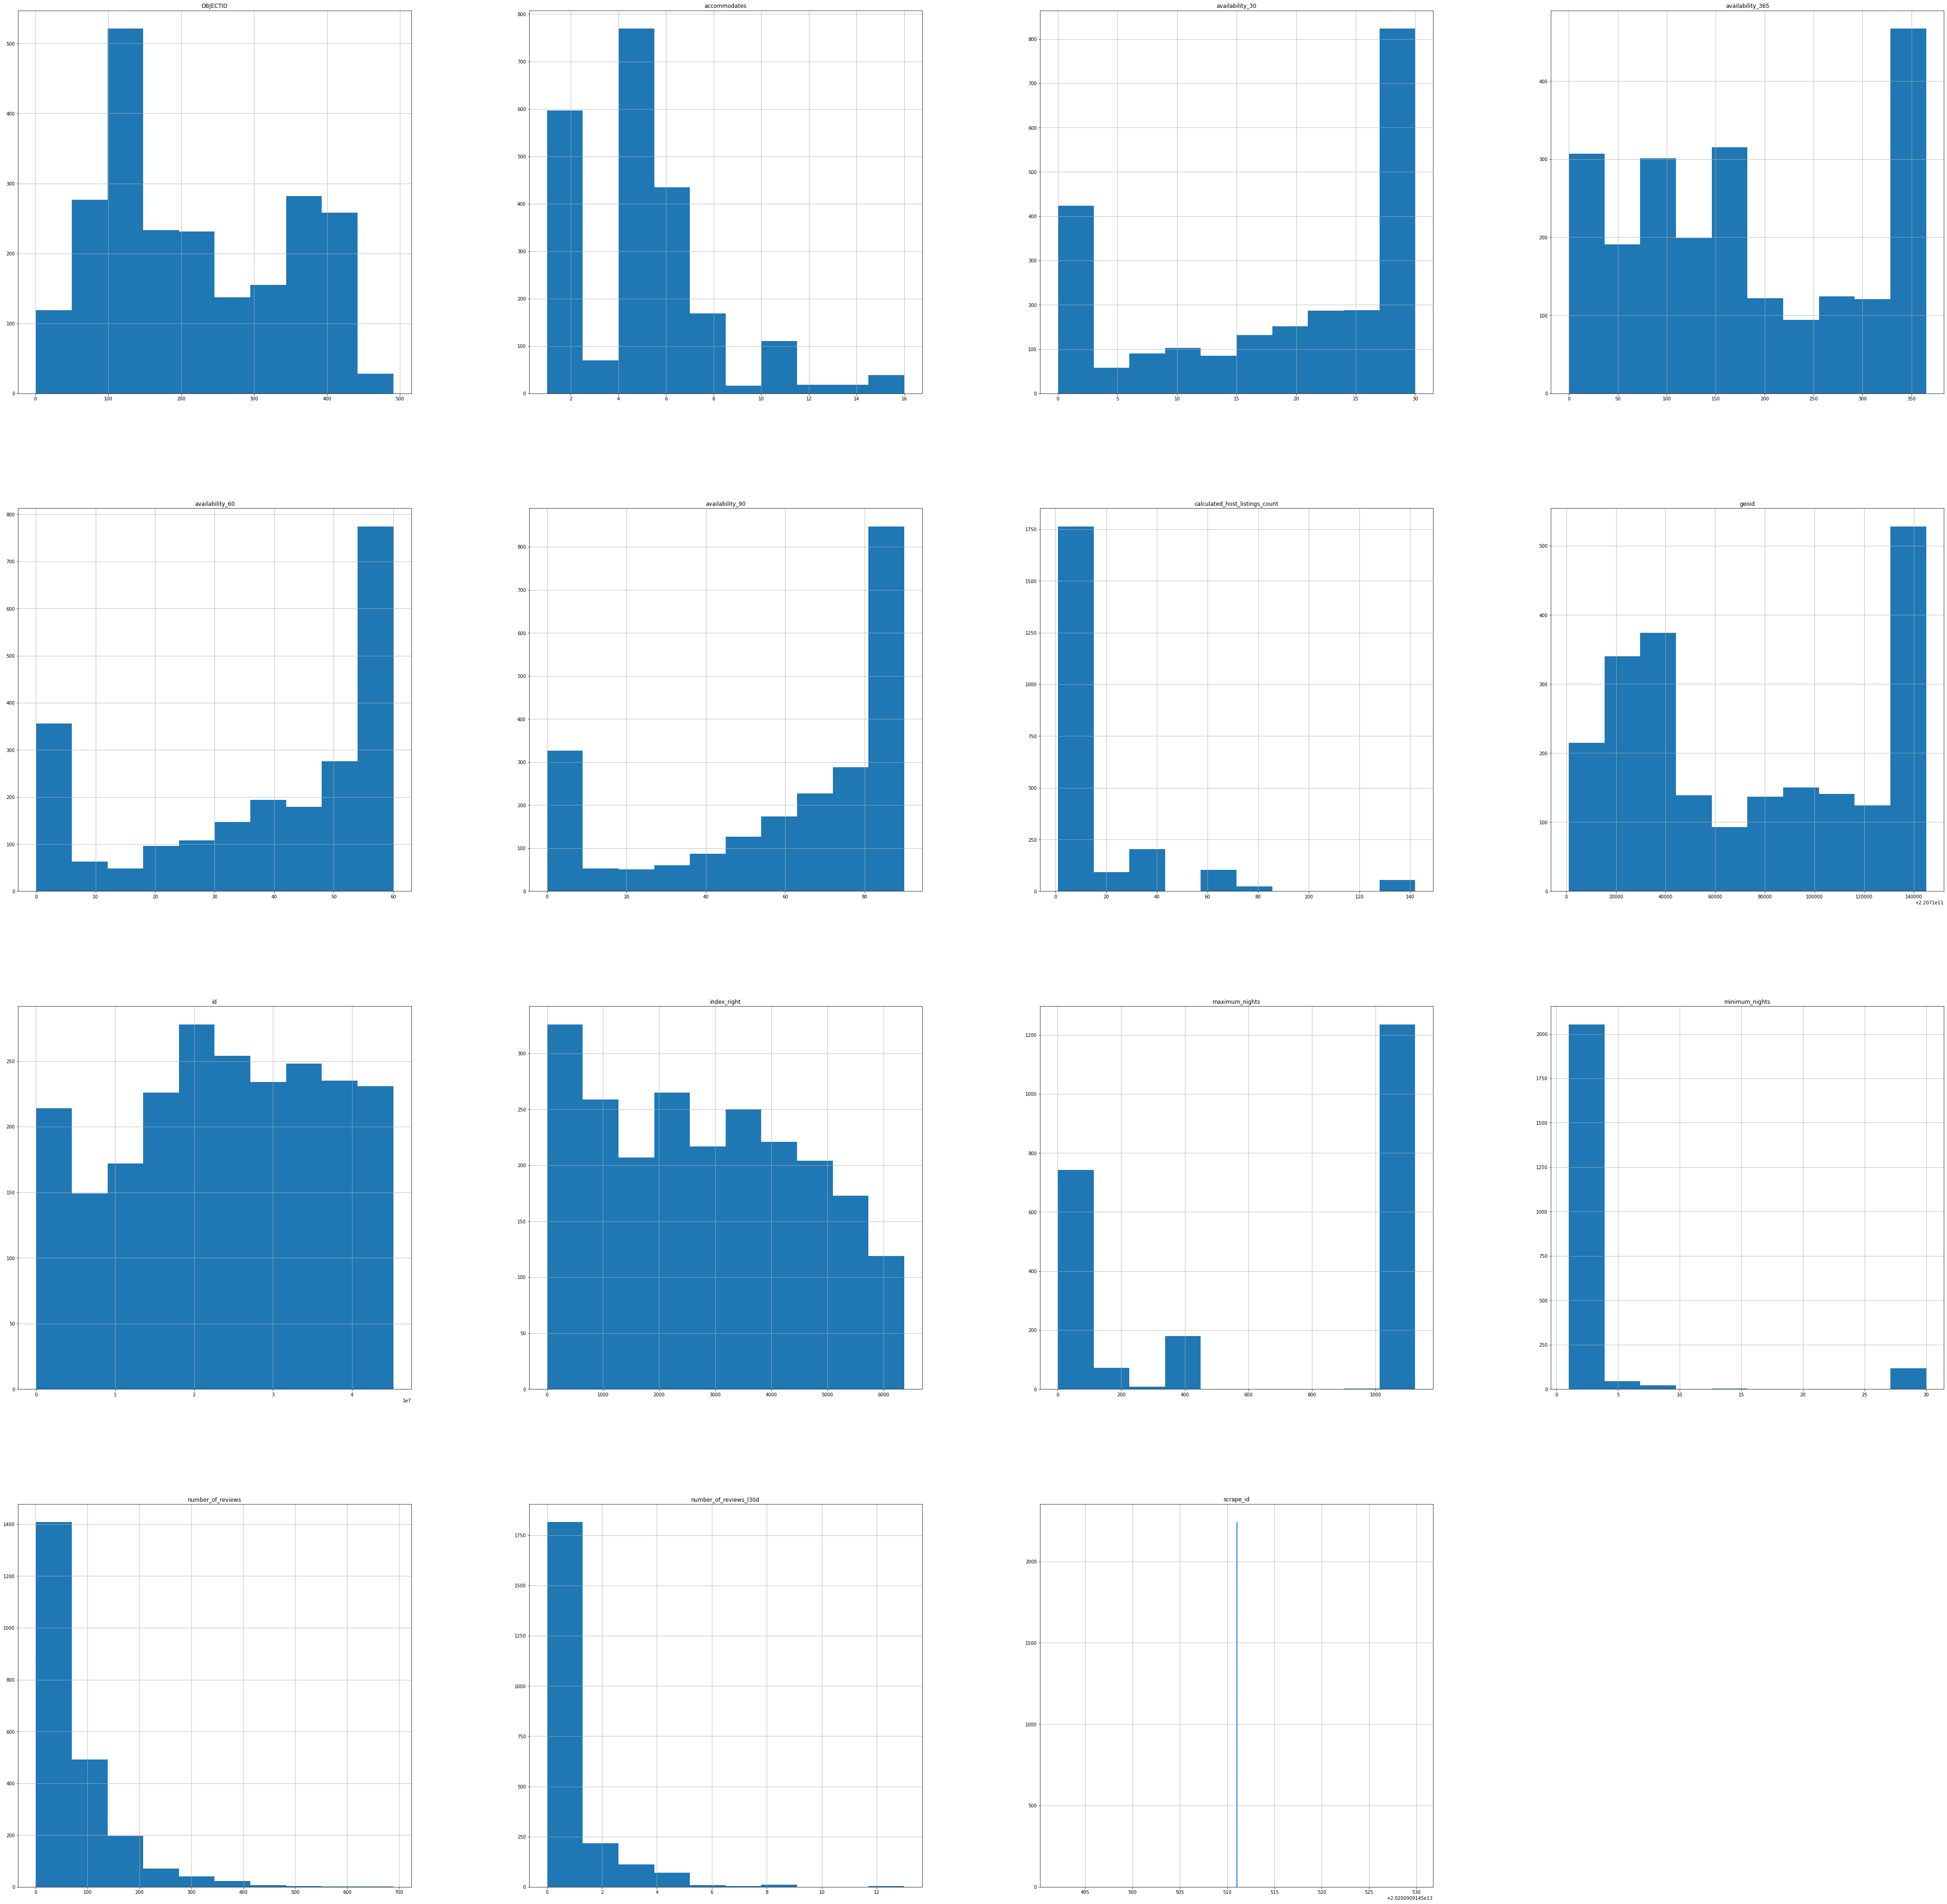

In [65]:
geolistings[ints].hist(bins = 10, figsize= (75,75))
#the code below saves the charts to a pdf for easier viewing
pyplot.savefig('../reports/figures/amenities_histograms.pdf')

array([[<AxesSubplot:title={'center':'Median Sales Price'}>,
        <AxesSubplot:title={'center':'PercentShortTermRentals'}>,
        <AxesSubplot:title={'center':'Restaurant_Count'}>,
        <AxesSubplot:title={'center':'bathrooms_text'}>,
        <AxesSubplot:title={'center':'bedrooms'}>],
       [<AxesSubplot:title={'center':'beds'}>,
        <AxesSubplot:title={'center':'days_active'}>,
        <AxesSubplot:title={'center':'host_acceptance_rate'}>,
        <AxesSubplot:title={'center':'host_response_rate'}>,
        <AxesSubplot:title={'center':'latitude'}>],
       [<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'lowest_estimate/month'}>,
        <AxesSubplot:title={'center':'middle_estimate/month'}>,
        <AxesSubplot:title={'center':'neighborhood_restaurants'}>,
        <AxesSubplot:title={'center':'price'}>],
       [<AxesSubplot:title={'center':'review_scores_accuracy'}>,
        <AxesSubplot:title={'center':'review_scores_checkin'}>,
   

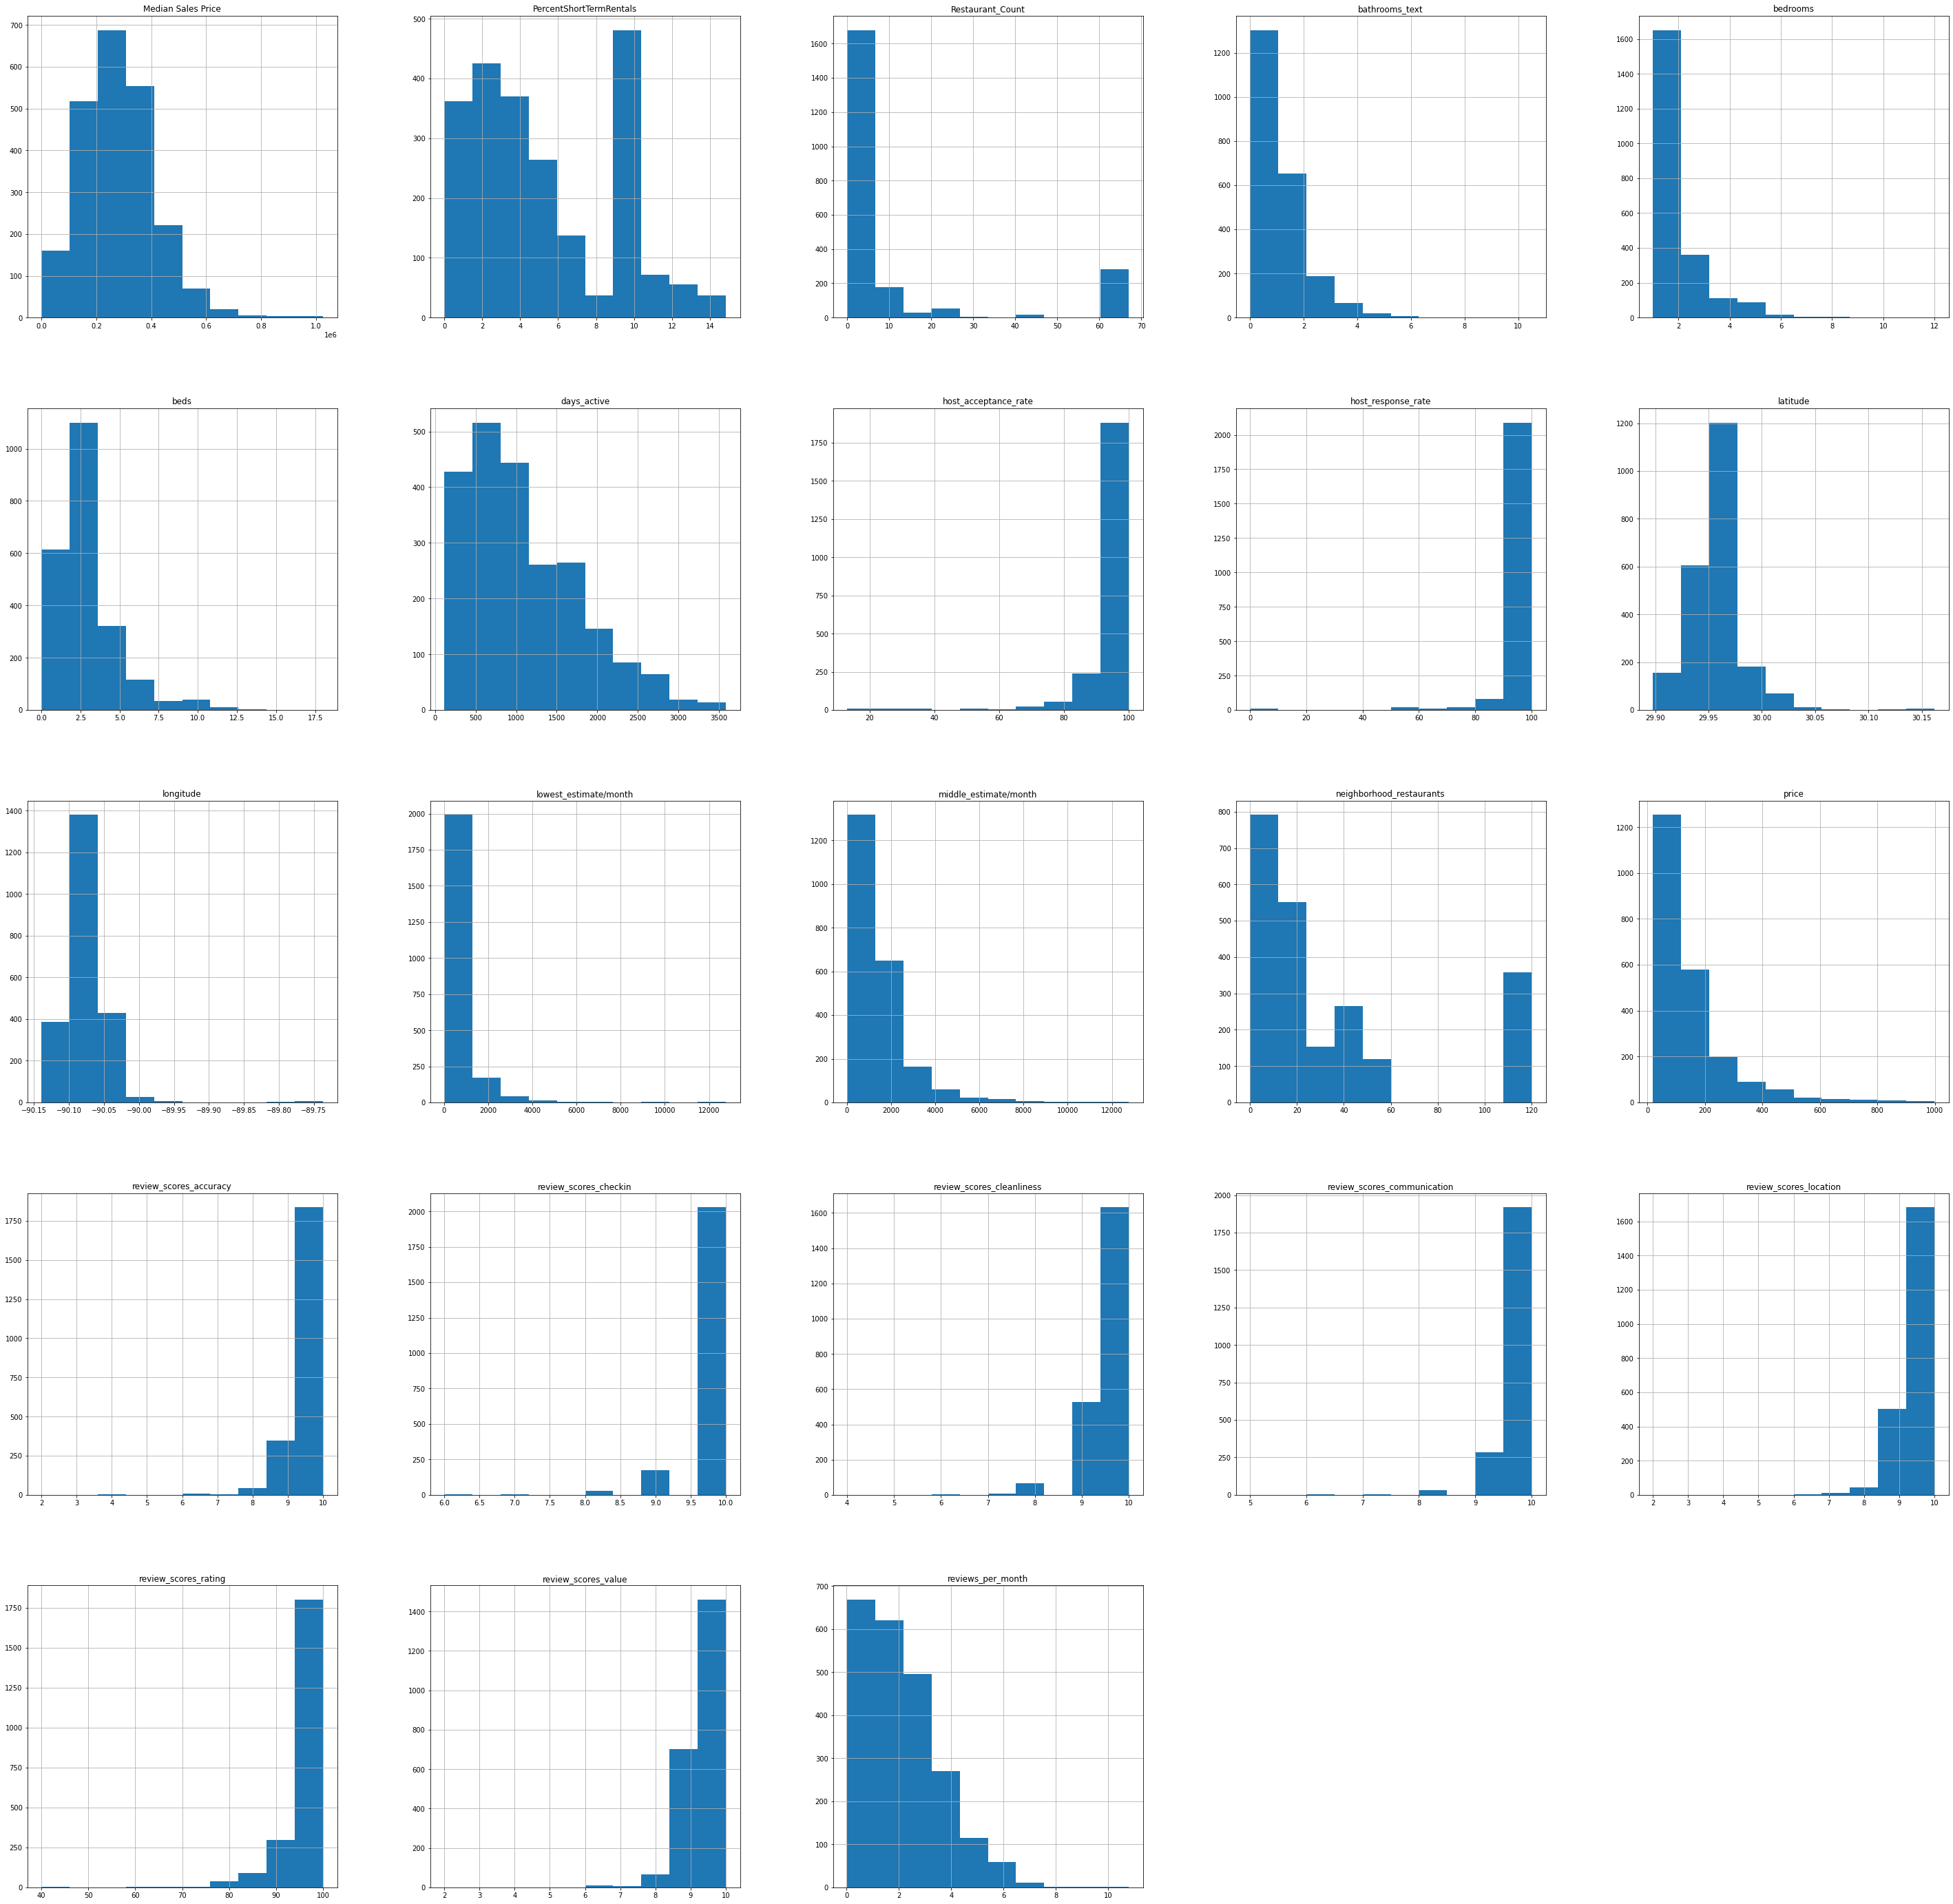

In [66]:
geolistings[floats].hist(bins = 10, figsize= (50,50))

In [67]:
#this deletes any columns where each instance has the same value. These won't be useful 
print(geolistings.shape)
for col in geolistings.columns:
    if len(geolistings[col].unique()) == 1:
        geolistings.drop(col,inplace=True,axis=1)
print(geolistings.shape)

(2241, 55)
(2241, 54)


I think the data is clean enough for EDA.  There will definitely be features removed after looking at it. 
I'm not sure if the target feature will be price per night.
I'd rather make a model that can estimate how much an owner can make per month depending on controllable factors. 


In [68]:
geolistings.to_csv(r'/Users/John/Desktop/Capstone_Two/data/cleaned_for_eda/airbnb.csv', index = False)